<a href="https://colab.research.google.com/github/AaryaAshok77/BrainTumourDetector_DeepLearning/blob/main/Brain_Tumour_Detector_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Setup

## Importing Packages

In [271]:
import sys
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score #? Helps form a yes no matrix for learning, check accuracy of our model
import cv2 #? Helps read image data -> Computer Vision

import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

## Reading the images

In [272]:
# from google.colab import drive
# drive.mount ('/content/drive', force_remount=True)
# tumour = []
# path_tumour = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/yes/*.jpg"
# path_healthy = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/no/*.jpg"


#* Reading the tumorous images from the dataset
tumour = []
path_tumour = "brain_tumor_dataset/yes/*.jpg"

for f in glob.iglob(path_tumour):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128)) #? Resizing the image to 128x128
    b, g, r = cv2.split(img) #?S plitting the image into its RGB components
    img = cv2.merge([r, g, b], img) #? Merging the RGB components to form the image
    tumour.append(img)
print(f"Tumorous: {len(tumour)}")

#* Reading the healthy images from the dataset
healthy = []
path_healthy = "brain_tumor_dataset/no/*.jpg"

for f in glob.iglob(path_healthy):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b], img)
    healthy.append(img)
print(f"Healthy: {len(healthy)}")

Tumorous: 154
Healthy: 97


In [273]:
tumour = np.array(tumour)
healthy = np.array(healthy)
print(f"Tumorous: {tumour.shape}") #? 155 images of 128x128 pixels with 3 channels (RGB)
print(f"Healthy: {healthy.shape}") #? 98 images of 128x128 pixels with 3 channels (RGB)

Tumorous: (154, 128, 128, 3)
Healthy: (97, 128, 128, 3)


In [274]:
all = np.concatenate((tumour, healthy)) #? Concatenating the tumorous and healthy images to form a single dataset
print(f"All: {all.shape}") #? 253 images of 128x128 pixels with 3 channels (RGB)

All: (251, 128, 128, 3)


### Visualizing the MRI image

In [275]:
def plot_random_img(healthy, tumour, n):
    healthy_imgs =  healthy[np.random.choice(healthy.shape[0], n, replace=False)] #? Randomly selecting 5 healthy images
    tumour_imgs =  tumour[np.random.choice(tumour.shape[0], n, replace=False)] #? Randomly selecting 5 tumorous images

    plt.figure(figsize=(16, 9)) #? Setting the size of the plot
    for img in range(n):
        plt.subplot(1, n, img+1) #? 1-> Row, num-> Column, img+1-> Index
        plt.title('Healthy')
        plt.imshow(healthy_imgs[img])

    plt.figure(figsize=(16, 9))
    for img in range(n):
        plt.subplot(2, n, img+1+n) #? 2-> Row, num-> Column, img+1+n-> Index
        plt.title('Tumorous')
        plt.imshow(tumour_imgs[img])

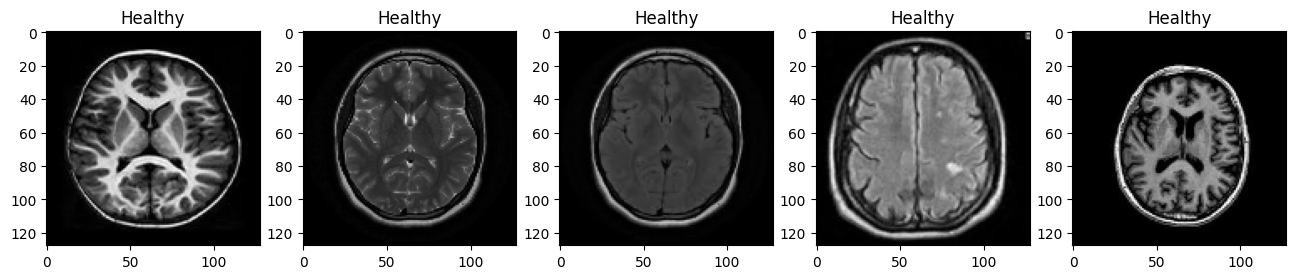

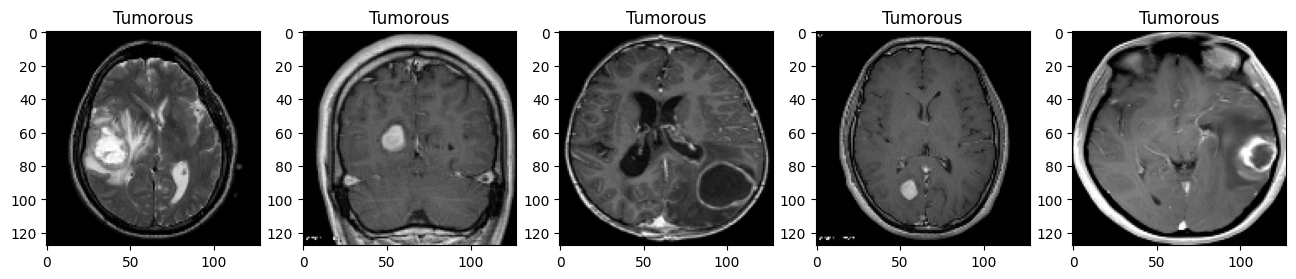

In [276]:
plot_random_img(healthy, tumour, 5)

## Creating MRI Dataset Class

In [277]:
class MRI(Dataset):
    def __init__(self):
        tumour = []
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b], img)
            tumour.append(img)

        healthy = []
        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b], img)
            healthy.append(img)

        #* Images
        tumour = np.array(tumour, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        #* Labels
        tumour_label = np.ones(tumour.shape[0], dtype=np.float32) #? 1-> Tumorous
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32) #? 0-> Healthy

        #* Concatenating the images and labels
        self.images = np.concatenate((tumour, healthy), axis=0) #? axis=0-> Concatenating along the rows ((154, 128, 128, 3)+(97, 128, 128, 3)=(251, 128, 128, 3))
        self.labels = np.concatenate((tumour_label, healthy_label), axis=0)

    def __len__(self): #? Returns the length of the dataset
        return self.images.shape[0]

    def __getitem__(self, idx): #? Returns the image and its label
        sample = {'image': np.transpose(self.images[idx], (2, 0, 1)), 'label': self.labels[idx]} 
        return sample
    
    def normalise(self):
        self.images /= 255.0 #? Normalising the images to the range [0, 1]

In [278]:
mri = MRI()
mri.normalise()

## Creating MRI Model using CNN

In [279]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            #* Layer 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), #? 3-> Input channels(128*128*3 image), 6-> Output channels, 5-> Kernel size
            #? Output size = (W-F+2P)/S+1 = (128-5+2*0)/1+1 = 124
            nn.Tanh(), #? Activation function (squashes the output to the range [-1, 1])
            nn.AvgPool2d(kernel_size=2, stride=5), #? 2-> Kernel size, 5-> Stride
            #? Output size = (W-F)/S+1 = (124-2)/5+1 = 25
            #* Layer 2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            #? Output size = (W-F+2P)/S+1 = (25-5+2*0)/1+1 = 21
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
            #? Output size = (W-F)/S+1 = (21-2)/5+1 = 5
            #! 4*4*16 = 256, 4 is the width and height of the image, 16 is the number of channels after the second convolution
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120), #? 256-> Input features, 120-> Output features
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1) #? 1-> Output feature
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) #? Flattening the output of the CNN model, 0-> Batch size, -1-> Number of features
        '''
            x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
            x= x.reshape(2, 2, 2, 2)
            x.size(0) -> 2
            x.view(-1) -> tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
            x.view(x.size(0), -1) -> tensor([[ 1,  2,  3,  4,  5,  6,  7,  8], [ 9, 10, 11, 12, 13, 14, 15, 16]])
        '''
        x = self.fc_model(x)
        x = F.sigmoid(x) #? Activation function (squashes the output to the range [0, 1])
        return x

## Evaluating the untrained CNN

In [280]:
mri_data = MRI()
mri_data.normalise()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #? Checking if GPU is available
print(f"Device: {device}")

model = CNN().to(device) #? Moving the model to the GPU

Device: cpu


In [281]:
dataloader = DataLoader(mri_data, batch_size=32, shuffle=False) #? Creating a dataloader

In [282]:
model.eval() #? Setting the model to evaluation mode
outputs = []
y_true = []

with torch.no_grad(): #? Disabling gradient calculation
    for d in dataloader:
        image = d['image'].to(device)
        label = d['label'].to(device)

        y_hat = model(image) #? Forward pass

        outputs.append(y_hat.detach().cpu().numpy())
        y_true.append(label.detach().cpu().numpy())
    

In [283]:
outputs = np.concatenate(outputs, axis=0).squeeze() #? Concatenating the output and reshaping it
y_true = np.concatenate(y_true, axis=0).squeeze() #? Concatenating the true labels and reshaping it

In [284]:
def threshold(x, threshold=0.5): #? threshold is 0.5 because the sigmoid function squashes the output to the range [0, 1]
    x = np.array(list(x))
    x[x >= threshold] = 1
    x[x < threshold] = 0
    return x

In [285]:
accuracy_score(y_true, threshold(outputs)) #? Checking the accuracy of the model

0.4820717131474104

### Visualizing our Model

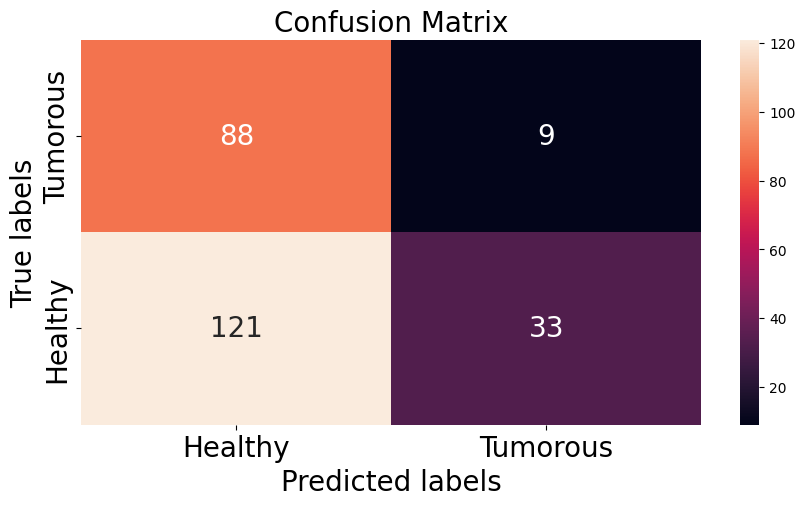

In [286]:
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)

# Setting tick labels for x-axis and y-axis
ax.set_xticklabels(['Healthy', 'Tumorous'], fontsize=20)
ax.set_yticklabels(['Tumorous', 'Healthy'], fontsize=20)

plt.show() #! We can see that currently our model thinks that everyone has a tumour

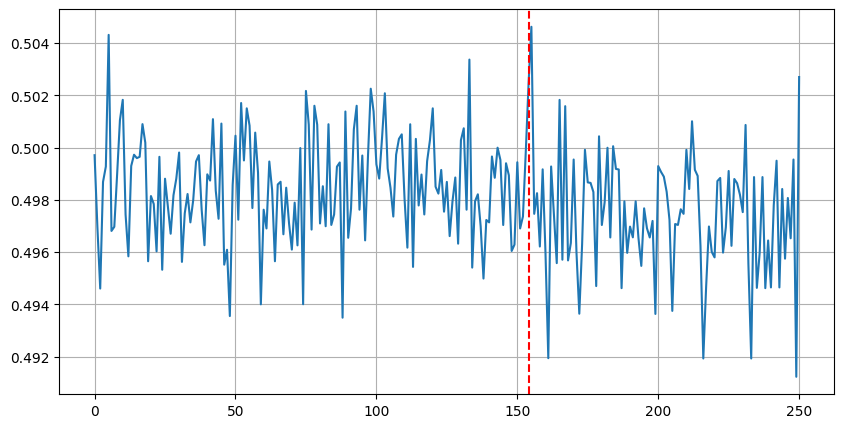

In [287]:
plt.figure(figsize=(10, 5))
plt.plot(outputs, label='Predicted')
plt.axvline(x=len(tumour), color='r', linestyle='--', label='True') #? 
plt.grid()

## Training the Model

In [288]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #? Optimiser

epoch = 400
dataloader = DataLoader(mri_data, batch_size=32, shuffle=True) #? Dataloader
model.train() #? Setting the model to training mode

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [289]:
for e in range(epoch):
    losses = []
    for d in dataloader:
        optimizer.zero_grad() #? Zeroing the gradients to avoid accumulation of gradients

        image = d['image'].to(device)
        label = d['label'].to(device)

        y_hat = model(image) #? Forward pass

        #* Define the loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label)) #? y_hat.squeeze because y_hat has shape of [32, 1] while label is [32]
        loss.backward() #? Backward pass

        optimizer.step() #? Optimiser step, will update the weights and biases based on the gradients calculated during the backward pass

        losses.append(loss.item())
    if e % 10 == 0:
        print(f"Epoch: {e}, Loss: {np.mean(losses)}")


Epoch: 0, Loss: 0.6872554048895836
Epoch: 10, Loss: 0.6127086952328682
Epoch: 20, Loss: 0.5344796068966389
Epoch: 30, Loss: 0.5226238369941711
Epoch: 40, Loss: 0.5136174894869328
Epoch: 50, Loss: 0.5037152953445911
Epoch: 60, Loss: 0.49205804243683815
Epoch: 70, Loss: 0.4760802090167999
Epoch: 80, Loss: 0.4671274647116661
Epoch: 90, Loss: 0.45444969832897186
Epoch: 100, Loss: 0.4382656589150429
Epoch: 110, Loss: 0.41801707819104195
Epoch: 120, Loss: 0.39638394117355347
Epoch: 130, Loss: 0.3819679766893387
Epoch: 140, Loss: 0.37349654361605644
Epoch: 150, Loss: 0.3503183126449585
Epoch: 160, Loss: 0.3311503119766712
Epoch: 170, Loss: 0.31116345524787903
Epoch: 180, Loss: 0.29485516995191574
Epoch: 190, Loss: 0.2759576290845871
Epoch: 200, Loss: 0.25752233900129795
Epoch: 210, Loss: 0.2407720871269703
Epoch: 220, Loss: 0.2522869370877743
Epoch: 230, Loss: 0.20367902237921953
Epoch: 240, Loss: 0.1911440435796976
Epoch: 250, Loss: 0.17448729928582907
Epoch: 260, Loss: 0.16607619542628527
E

### Evaluating the trained Model

In [294]:
model.eval()
dataloader = DataLoader(mri_data, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    for d in dataloader:
        image = d['image'].to(device)
        label = d['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.detach().cpu().numpy())
        y_true.append(label.detach().cpu().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [295]:
accuracy_score(y_true, threshold(outputs))

1.0

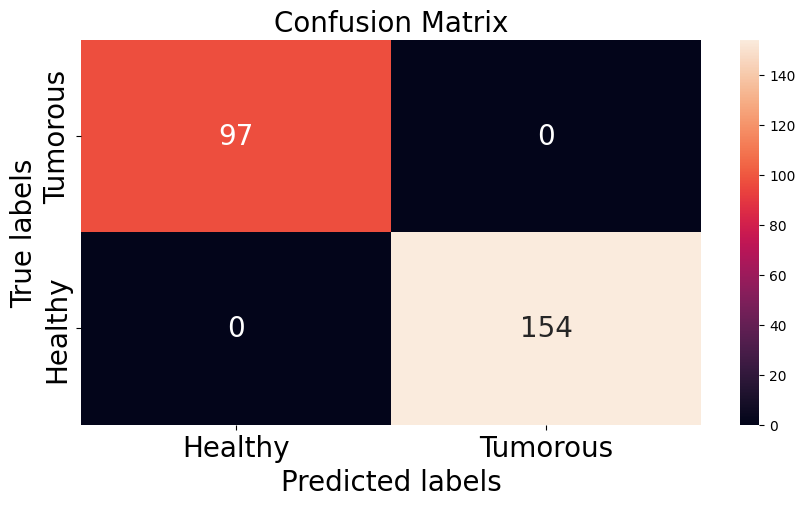

In [296]:
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)

ax.set_xticklabels(['Healthy', 'Tumorous'], fontsize=20)
ax.set_yticklabels(['Tumorous', 'Healthy'], fontsize=20)

plt.show() #! Our model now accurately predicts the tumorous and healthy images

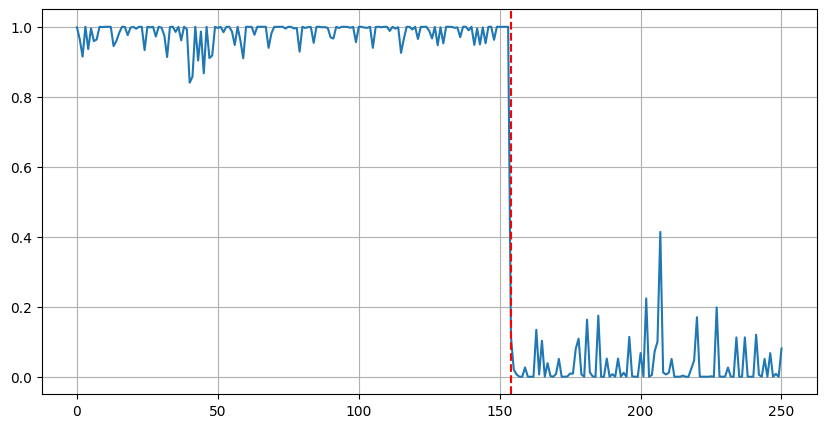

In [297]:
plt.figure(figsize=(10, 5))
plt.plot(outputs, label='Predicted')
plt.axvline(x=len(tumour), color='r', linestyle='--', label='True')
plt.grid()